In [2]:
! pip install python-dp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 6.7 MB/s eta 0:00:00


In [3]:
! pip install pycanon

In [109]:
import pandas as pd
import numpy as np
from hashlib import sha256
from pydp.algorithms.laplacian import BoundedMean
from pycanon import anonymity, report

In [157]:
data = pd.read_csv('/content/Employees.csv')
data.head()

,EmpID,FirstName,LastName,Title,Email,Password,EmployeeType,PayZone,DepartmentType,DOB,JobFunctionDescription,GenderCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,monthly_salary
0,3427,Uriah,Bridges,Production Technician I,uriah.bridges@bilearner.com,uriahbridges3427,Contract,Zone C,Production,07-10-1969,Accounting,Female,White,Widowed,Fully Meets,4,6877
1,3428,Paula,Small,Production Technician I,paula.small@bilearner.com,paulasmall3428,Contract,Zone A,Production,30-08-1965,Labor,Male,Hispanic,Widowed,Fully Meets,3,5383
2,3429,Edward,Buck,Area Sales Manager,edward.buck@bilearner.com,edwardbuck3429,Full-Time,Zone B,Sales,06-10-1991,Assistant,Male,Hispanic,Widowed,Fully Meets,4,4722
3,3430,Michael,Riordan,Area Sales Manager,michael.riordan@bilearner.com,michaelriordan3430,Contract,Zone A,Sales,04-04-1998,Clerk,Male,Other,Single,Fully Meets,2,4779
4,3431,Jasmine,Onque,Area Sales Manager,jasmine.onque@bilearner.com,jasmineonque3431,Contract,Zone A,Sales,29-08-1969,Laborer,Female,Other,Married,Fully Meets,3,4638


In [111]:
data['FirstName'] = 'Empleado' + data['EmpID'].astype(str)

In [112]:
# Borra LastName
data.drop('EmpID', axis=1, inplace=True)
data.drop('LastName', axis=1, inplace=True)
data.drop('JobFunctionDescription', axis=1, inplace=True)
data.drop('Title', axis=1, inplace=True)

In [113]:
# Enmascarar parte del correo manteniendo el dominio
data['Email'] = data['Email'].apply(lambda x: 'employee' + str(hash(x))[:5] + '@' + x.split('@')[-1])

In [114]:
# Crear mapeo para pseudonimización
employee_type_mapping = {
    'Contract': 'C',
    'Full-Time': 'F/T',
    'Part-Time': 'P/T'
}

pay_zone_mapping = {
    'Zone C': 1,
    'Zone A': 2,
    'Zone B': 3
}

gender_code_mapping = {
    'Female': 'GenderA',
    'Male': 'GenderB'
}

performance_mapping = {
    'Fully Meets': 'Performance-FM',
    'Exceeds': 'Performance-E',
    'Needs Improvement': 'Performance-NI',
    'PIP': 'Performance-P'
}

race_desc_mapping = {
    'White': 1,
    'Hispanic': 2,
    'Other': 3,
    'Black': 4,
    'Asian': 5
}

marital_desc_mapping = {
    'Widowed': 'Not Married',
    'Single': 'Not Married',
    'Married': 'Married',
    'Divorced': 'Married'
}

data['EmployeeType'] = data['EmployeeType'].map(employee_type_mapping)
data['PayZone'] = data['PayZone'].map(pay_zone_mapping)
data['GenderCode'] = data['GenderCode'].map(gender_code_mapping)
data['Performance Score'] = data['Performance Score'].map(performance_mapping)
data['RaceDesc'] = data['RaceDesc'].map(race_desc_mapping)
data['MaritalDesc'] = data['MaritalDesc'].map(marital_desc_mapping)

In [115]:
from datetime import datetime

# Convertir DOB a un formato datetime para calcular edad
data['DOB'] = pd.to_datetime(data['DOB'], format='%d-%m-%Y')
data['DOB'] = datetime.now().year - data['DOB'].dt.year

In [116]:
# Definir los rangos de edad
bins = [0, 24, 34, 44, 54, 64, 74, 100]
labels = ["<25", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"]

# Crear una nueva columna con el rango de edad
data['DOB'] = pd.cut(data['DOB'], bins=bins, labels=labels, right=False)

In [117]:
# Renombra la columna DOB
data.rename(columns={'DOB': 'Age'}, inplace=True)
data.rename(columns={'FirstName': 'Name'}, inplace=True)

In [118]:
data['monthly_salary'].describe()

,monthly_salary
count,3002.000000
mean,4612.056962
std,1121.178392
min,2216.000000
25%,3735.000000
50%,4522.500000
75%,5349.750000
max,8426.000000


In [119]:
from pycanon import anonymity, report

QI = ["Performance Score", "Current Employee Rating"]
SA = ["monthly_salary"]

k = anonymity.k_anonymity(data, QI)

report.print_report(data, QI, SA)

The dataset verifies:
          	 - k-anonymity with k = 6
          	 - (alpha,k)-anonymity with alpha = 0.16666666666666666 and k = 6
          	 - l-diversity with l = 6
          	 - entropy l-diversity with l = 5
          	 - (c,l)-diversity with c = 2 and l = 6
          	 - basic beta-likeness with beta = 499.3333333333333
          	 - enhanced beta-likeness with beta = 8.007034012193408
          	 - t-closeness with t = 0.4088774071779199
          	 - delta-disclosure privacy with delta = 6.215274542965353


In [153]:
from pydp.algorithms.laplacian import BoundedMean

lower_bound = data['monthly_salary'].min()
upper_bound = data['monthly_salary'].max()
epsilon = 35

def calculate_dp_average_salary(data, epsilon, lower, upper):
    dp_mean = BoundedMean(epsilon=epsilon, lower_bound=lower, upper_bound=upper)
    dp_mean.add_entries(data)
    return dp_mean.result()

dp_average_salary = calculate_dp_average_salary(data['monthly_salary'].values, epsilon, lower_bound, upper_bound)
data['dp_average_salary'] = dp_average_salary
print(f"Promedio de salario con privacidad diferencial: {dp_average_salary}")

Promedio de salario con privacidad diferencial: 4611.990672884744


In [154]:
data.head()

,Name,Email,Password,EmployeeType,PayZone,DepartmentType,Age,GenderCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,monthly_salary,dp_average_salary
0,Empleado3427,employee47802@bilearner.com,uriahbridges3427,C,1,Production,55-64,GenderA,1,Not Married,Performance-FM,4,6877,4611.990673
1,Empleado3428,employee42346@bilearner.com,paulasmall3428,C,2,Production,55-64,GenderB,2,Not Married,Performance-FM,3,5383,4611.990673
2,Empleado3429,employee-6556@bilearner.com,edwardbuck3429,F/T,3,Sales,25-34,GenderB,2,Not Married,Performance-FM,4,4722,4611.990673
3,Empleado3430,employee-4223@bilearner.com,michaelriordan3430,C,2,Sales,25-34,GenderB,3,Not Married,Performance-FM,2,4779,4611.990673
4,Empleado3431,employee20313@bilearner.com,jasmineonque3431,C,2,Sales,55-64,GenderA,3,Married,Performance-FM,3,4638,4611.990673


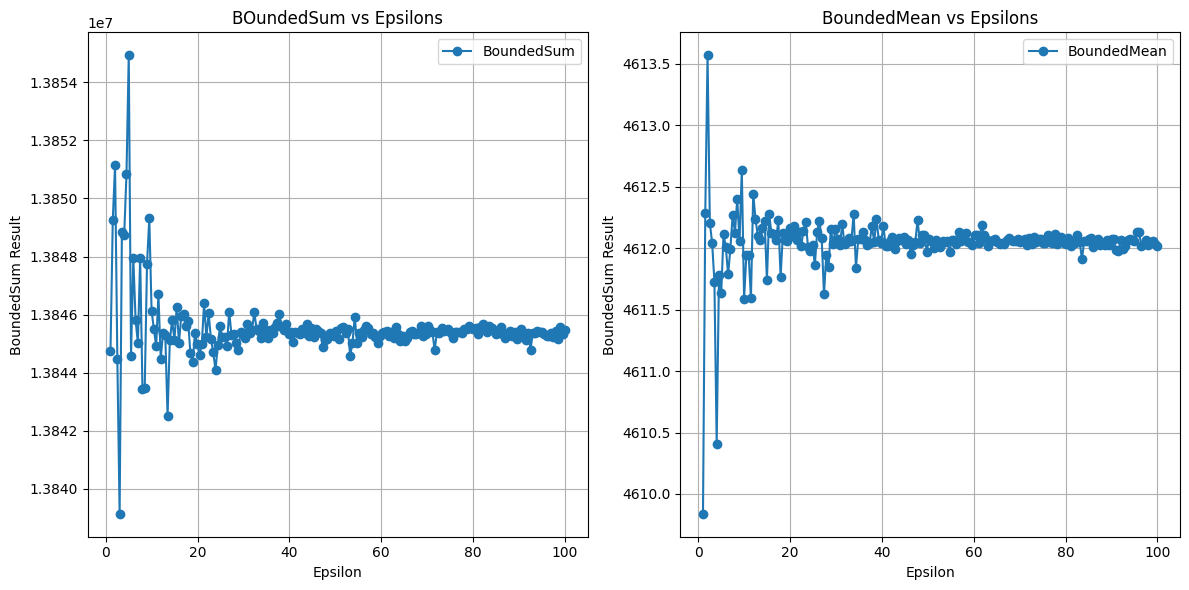

4612.056962025316


In [94]:
from pydp.algorithms.laplacian import BoundedSum
import matplotlib.pyplot as plt
import numpy as np
df = data['monthly_salary']

lower = data['monthly_salary'].min()
upper = data['monthly_salary'].max()
realSum = sum(df)
realMean = np.mean(df)

epsilons = np.linspace(1, 100, 200)

results_sum = []
results_mean = []

for eps in epsilons:
  bsum = BoundedSum(epsilon=eps,lower_bound = lower, upper_bound=upper )
  bsum.add_entries(df)
  results_sum.append(bsum.result())

  bmean = BoundedMean(epsilon=eps,lower_bound = lower, upper_bound=upper )
  bmean.add_entries(df)
  results_mean.append(bmean.result())

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epsilons, results_sum, marker="o", linestyle ='-', label="BoundedSum")
plt.title("BOundedSum vs Epsilons")
plt.xlabel("Epsilon")
plt.ylabel("BoundedSum Result")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epsilons, results_mean, marker="o", linestyle ='-', label="BoundedMean")
plt.title("BoundedMean vs Epsilons")
plt.xlabel("Epsilon")
plt.ylabel("BoundedSum Result")
plt.legend()
plt.grid(True)
plt.plot()

plt.tight_layout()
plt.show()
print(realMean)

In [156]:
# Guarda en un archivo csv data
data.to_csv('Employees_anonymized.csv', index=False)

In [155]:
data.head()

,Name,Email,Password,EmployeeType,PayZone,DepartmentType,Age,GenderCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating,monthly_salary,dp_average_salary
0,Empleado3427,employee47802@bilearner.com,uriahbridges3427,C,1,Production,55-64,GenderA,1,Not Married,Performance-FM,4,6877,4611.990673
1,Empleado3428,employee42346@bilearner.com,paulasmall3428,C,2,Production,55-64,GenderB,2,Not Married,Performance-FM,3,5383,4611.990673
2,Empleado3429,employee-6556@bilearner.com,edwardbuck3429,F/T,3,Sales,25-34,GenderB,2,Not Married,Performance-FM,4,4722,4611.990673
3,Empleado3430,employee-4223@bilearner.com,michaelriordan3430,C,2,Sales,25-34,GenderB,3,Not Married,Performance-FM,2,4779,4611.990673
4,Empleado3431,employee20313@bilearner.com,jasmineonque3431,C,2,Sales,55-64,GenderA,3,Married,Performance-FM,3,4638,4611.990673
